In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

from tqdm import tqdm
from copy import deepcopy
from timeit import default_timer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, log_loss
from sklearn.metrics import RocCurveDisplay, roc_curve, auc


import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
# from apex import amp

import gc
# from numba import cuda

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
simulations = np.load('/content/drive/MyDrive/simulations.npy', allow_pickle=True)
dataset = np.load('/content/drive/MyDrive/dataset.npy', allow_pickle=True)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# N = simulations.shape[0]
N = 800
X = torch.from_numpy(simulations[:N].reshape(N, 1, 513, 513)).half().to(device)
y = torch.from_numpy(dataset[:N].reshape(N, 1, 513, 513)).half().to(device)

In [5]:
del simulations
del dataset

In [7]:
bs = 20

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=bs)
val_loader = DataLoader(val_data, batch_size=bs)
test_loader = DataLoader(test_data, batch_size=bs)

scaler = torch.cuda.amp.GradScaler()

In [6]:
del X_train, X_val_test, y_train, y_val_test
del X_val, y_val
del train_data, val_data

In [11]:
def train(model, criterion, optimizer, X, y, n_epochs, n_stop=10):
    # total_size = dataset.shape[0]
    # train_dataset, val_dataset, test_dataset = random_split(dataset, 
                                            # [int(total_size * 0.7), int(total_size * 0.2), int(total_size * 0.1)])
    # train_loss = list()
    # val_loss = list()
    min_val_loss = np.inf
    f = 0
    # t0 = default_timer()
    for epoch in range(n_epochs):
        # t1 = default_timer()
        model.train()
        # train_batch_loss = list()
        # mean_train_batch_loss = 
        for batch in train_loader:
            optimizer.zero_grad()
            _X, _y = batch
            _X, _y = _X.to(device), _y.to(device)
          
            # loss.backward()
            # optimizer.step()
            # train_batch_loss.append(loss.item())
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                _y_pred = model(_X)
                loss = criterion(_y_pred, _y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        model.eval()
        # val_batch_loss = list()
        mean_val_loss = 0
        batch_count = 0
        for batch in val_loader:
            _X, _y = batch
            _X, _y = _X.to(device), _y.to(device)
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                _y_pred = model(_X)
                loss = criterion(_y_pred, _y)
            mean_val_loss += loss.item()
            batch_count += 1
            # val_batch_loss.append(loss.item())
        mean_val_loss /= batch_count
        # t2 = default_timer()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, \tValidation loss: {(mean_val_loss)}')
        # train_loss.append(np.mean(train_batch_loss))
        # val_loss.append(np.mean(val_batch_loss))
        # val_loss = np.mean(val_batch_loss)
        # (optional) early stopping:

        if round(mean_val_loss, 3) >= min_val_loss:
            f = f + 1
        else:
            # print(f'epoch: {epoch}, val loss did decrease, saving model')
            f = 0
            best_model = deepcopy(model)
            # min_val_loss = round(mean_val_loss, 3)
        if f >= n_stop:
            print(f'epoch: {epoch}, val loss did not decrease for {f} epoch(s)')
            break

    return best_model #, train_loss, val_loss

In [9]:
def test_loss(model, criterion):
  y_pred = model(X_test).view(-1, 513, 513)
  loss = criterion(y_pred, y_test)
  return loss

In [9]:
# Define the CNN architecture
class CNN1(torch.nn.Module):
  def __init__(self):
    super(CNN1, self).__init__()
    self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding=1) # 513
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2)                # 256
    self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)# 256
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2)                # 128
    self.fc1 = torch.nn.Linear(64 * 128 * 128, 128)
    self.fc2 = torch.nn.Linear(128, 513 * 513)

  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = torch.relu(x)
    x = self.pool2(x)
    x = x.view(-1, 64 * 128 * 128)
    x = self.fc1(x)
    x = torch.relu(x)
    x = self.fc2(x)
    x = torch.relu(x)
    return x.view(-1, 1, 513, 513)

In [11]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) # now shape is (513, 513) 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # (256, 256)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # 256
        # self.maxpool2 = nn.MaxPool2d(kernel_size=4) # 32
        # self.fc1 = torch.nn.Linear(32 * 32 * 32, 513 * 513)
        # self.transconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=5, stride=4, padding=1, output_padding=1) # 128
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) # 64
        self.transconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, stride=4, padding=1, output_padding=1) # 256
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) # 128
        self.transconv3 = nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=5, stride=4, padding=1, output_padding=2) # 513
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Apply the layers in sequence
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.maxpool2(x)
        x = self.transconv1(x)
        x = nn.functional.relu(x)
        x = self.maxpool3(x)
        x = self.transconv2(x)
        x = nn.functional.relu(x)
        x = self.maxpool4(x)
        x = self.transconv3(x)
        x = self.conv3(x)
        # x = self.fc1(x)
        x = nn.functional.relu(x)
        
        return x


In [ ]:
# m = nn.MaxPool2d(kernel_size=4)
m = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=5, stride=4, padding=1, output_padding=1)
input = torch.randn(1, 32, 32)
output = m(input)
output.size()

In [12]:
# Instantiate the CNN
model = CNN1().to(device)
# model.half()
model.cuda()

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()#.half()
# criterion.half()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

with torch.autograd.detect_anomaly(check_nan=True):
  model = train(model, criterion, optimizer, X, y, n_epochs=10, n_stop=10)

<ipython-input-12-3f9761af243e>:11: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly(check_nan=True):


RuntimeError: ignored

In [14]:
model = torch.load('/content/drive/MyDrive/models/model1', map_location=torch.device('cpu')) # .to(device)
# model.cuda()

In [ ]:
# criterion = torch.nn.MSELoss()
print(f'Test loss: {test_loss(model, criterion)}')

In [11]:
torch.save(model, '/content/drive/MyDrive/models/model1')

In [9]:
from PIL import Image

In [10]:
circle_np = np.array(Image.open('/content/drive/MyDrive/images/im12.png').convert("L"))
circle =  torch.from_numpy(circle_np.reshape(1, 513, 513)).half().to(device)
circle_pred = model(circle).view(-1, 513, 513)

In [11]:
def frame_plot(arr, ax):
  rectX = np.linspace(0, 1, arr.shape[0])
  rectY = np.linspace(0, 1, arr.shape[1])
  x, y = np.meshgrid(rectX, rectY)
  ax.pcolormesh(x, y, arr)

In [12]:
circle_pred_np = circle_pred.cpu().detach().numpy().reshape(513, 513)

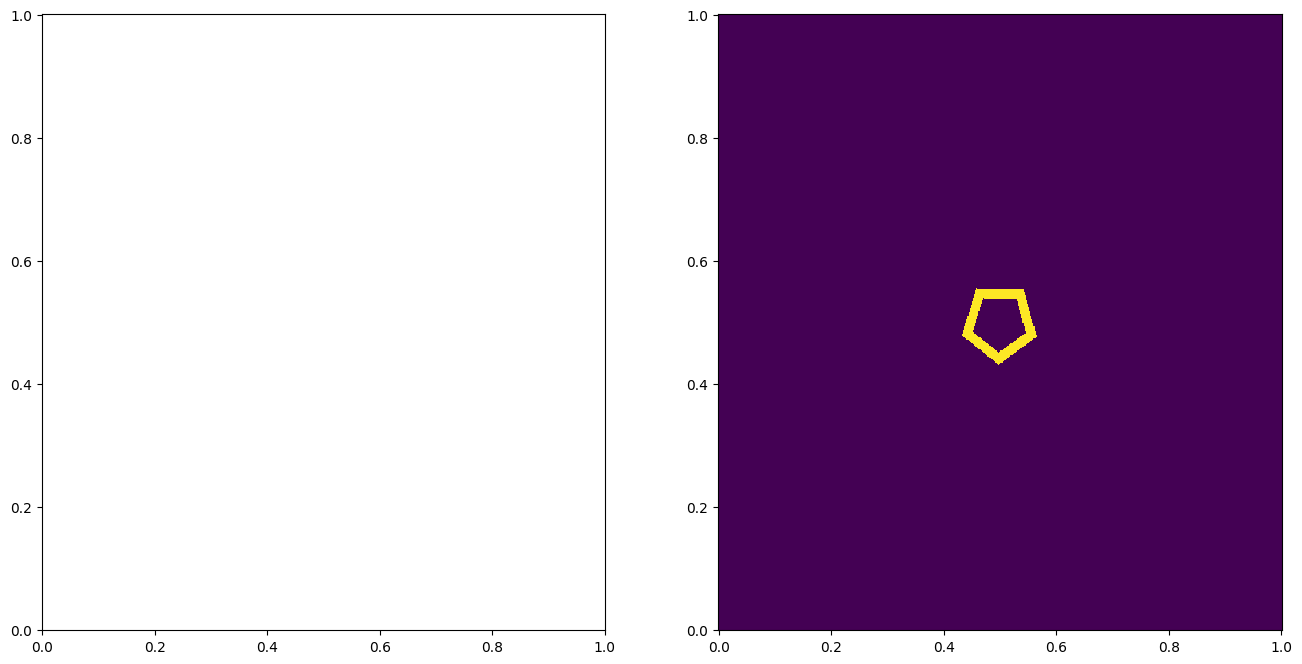

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
frame_plot(circle_pred_np, ax=ax[0])
frame_plot(circle_np, ax=ax[1])

In [14]:
circle_pred_np

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float16)

In [22]:
circle_im = Image.fromarray(circle_pred_np)
circle_im = circle_im.convert('L')
circle_im.save('/content/drive/MyDrive/prediction_test/im10.png')